In [1]:
import pandas as pd
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os
import geopandas
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math

In [2]:
# Months that we want to work with. We will limit them to the three months of the exercise but more could be added
months = ['03','06','11']

## Reading Data

We define some data reading functions:
- read_trips_data_download: reads the data for a list of months directly from the url and saves it as a pickle file to avoid downloading it every time
- read_trips_data_csv: We can download the data directly from the browser and read it from the trips_csv folder
- read_trips_data_pickle: reads the saved pickled files created by the two previous functions
- read_shapefile: reads the shapefile of the NYC areas that we will use for visualisation purposes

In [61]:
# We define some reading functions
# Download the data from the URLs 
def read_trips_data_download(months):
    list_of_dfs = []
    for month in months:
        url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-{0}.csv".format(month)
        df = pd.read_csv(url)
        df.to_pickle("df_trips_{0}.pkl".format(month))
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs)

# Unzip the trips_csv.zip file and load 
def read_trips_data_csv(months):
    with ZipFile('trips_csv.zip', 'r') as zfile:
        zfile.extractall('trips_csv')
    list_of_dfs = []
    for month in months:
        file_name = 'trips_csv/yellow_tripdata_2017-{0}.csv'.format(month)
        df = pd.read_csv(file_name)
        df.to_pickle("df_trips_{0}.pkl".format(month))
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs)

# Read from pickle if they have already been pickled with the read_trips_data_csv function
def read_trips_data_pickle(months):
    list_of_dfs = []
    for month in months:
        file_name = 'df_trips_{0}.pkl'.format(month)
        df = pd.read_pickle(file_name)
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs)

# Read the shapefile with the taxi areas
def read_shapefile(zip_url):
    resp = urlopen(zip_url)
    zipfile = ZipFile(BytesIO(resp.read()))
    fname = zipfile.namelist()[2]
    zipfile.extractall('taxi_zones')
    return geopandas.read_file(os.getcwd() + '/taxi_zones/{0}'.format(fname))

In [90]:
taxi_zone_shapefile_url = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip'
taxi_zones_df = read_shapefile(taxi_zone_shapefile_url)

In [62]:
trips_df = read_trips_data_csv(months)
# trips_df = read_trips_data_pickle(months) # uncomment if already pickled

## Data Exploration and Cleaning

In [65]:
# Some format options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [66]:
trips_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000,29236424.000
mean,1.546,1.618,2.919,1.043,163.202,161.191,1.329,13.109,0.334,0.497,1.874,0.329,0.300,16.447
std,0.498,1.261,4.477,0.510,66.614,70.478,0.490,147.282,0.462,0.071,2.646,1.969,0.014,147.525
min,1.000,0.000,0.000,1.000,1.000,1.000,1.000,-550.000,-53.710,-0.500,-112.000,-17.500,-0.300,-550.300
25%,1.000,1.000,0.970,1.000,114.000,107.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,8.750
50%,2.000,1.000,1.600,1.000,162.000,162.000,1.000,9.500,0.000,0.500,1.360,0.000,0.300,11.800
75%,2.000,2.000,3.010,1.000,233.000,233.000,2.000,14.500,0.500,0.500,2.460,0.000,0.300,17.800
max,2.000,192.000,9496.980,99.000,265.000,265.000,5.000,630461.820,69.800,140.000,450.000,1018.950,1.000,630463.120


From describing the dataframe we can already see several issues with the data.
- Outliers in passenger_count where some trips have 192 passengers
- Outliers in trip_distance with a max trip of 15000 km
- RateCodeId of 99 but it can only go from 1-6 through the data dictionary definition
- Outliers in the fare amount with trips of 630K dollars. Negative values too
- Extra can only be 0, 0.5 or 1 by the data dictionary
- Mta_tax can only be 0.50 or 0 by the data dictionary
- Tip amounts and tolls amount with negative values and outliers
- Improvement surcharge can only be 0.30 by the data dictionary

In [67]:
trips_df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

There are no NaN's so all the values are informed. Let's check the values in extra and confirm that they can only be 0, 0.5 or 1

In [68]:
trips_df['extra'].value_counts()

0.000      15291517
0.500       9189440
1.000       4625931
4.500        121310
-0.500         4821
             ...   
-17.730           1
0.740             1
-31.610           1
-16.000           1
-15.600           1
Name: extra, Length: 76, dtype: int64

Indeed most of the values are 0, 0.5 or 1, but there are also a lot of values for 4.500. Let's check what kind of rates have this value 

In [69]:
trips_df[trips_df['extra']==4.500]['RatecodeID'].value_counts()

2     121271
1         37
5          1
99         1
Name: RatecodeID, dtype: int64

Most of them are 2 = JFK. This is an special rate, so we are going to consider 4.5 as a valid value for extra. What about mta_tax

In [70]:
trips_df['mta_tax'].value_counts()

0.500      29088583
0.000        133414
-0.500        13639
0.850           655
0.250            62
3.000            13
7.680             7
0.900             4
0.370             4
0.320             4
0.350             3
103.300           2
140.000           1
11.300            1
0.930             1
53.800            1
10.300            1
43.000            1
11.400            1
53.530            1
13.400            1
17.800            1
96.000            1
1.300             1
17.400            1
14.650            1
7.400             1
97.750            1
89.000            1
49.440            1
24.000            1
0.750             1
36.410            1
18.530            1
39.400            1
32.410            1
31.550            1
3.450             1
69.990            1
46.520            1
54.510            1
43.800            1
51.360            1
0.780             1
31.000            1
14.480            1
Name: mta_tax, dtype: int64

It's indeed either 0.5 or 0. Finally improvement_surcharge, what kind of values do we have here?

In [71]:
trips_df['improvement_surcharge'].value_counts()

0.300     29214128
-0.300       14038
0.000         8216
1.000           29
0.250           10
0.500            2
0.550            1
Name: improvement_surcharge, dtype: int64

Seems like a fixed value of 0.3.

We can now create a filter that will only take as valid rows those with values inside the ranges that we have defined.

In [72]:
rows_to_keep = trips_df[['RatecodeID','extra', 'mta_tax', 'improvement_surcharge']].isin({'RatecodeID' : [1,2,3,4,5,6], 'extra' : [0,0.5,1,4.5], 'mta_tax' : [0.5, 0], 'improvement_surcharge' : [0.300]  }).all(axis='columns')

In [73]:
trips_df = trips_df[rows_to_keep]
trips_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000,29213703.000
mean,1.546,1.618,2.920,1.041,163.195,161.184,1.329,13.093,0.334,0.498,1.875,0.329,0.300,16.433
std,0.498,1.261,3.746,0.293,66.609,70.477,0.488,121.451,0.457,0.033,2.645,1.965,0.000,121.746
min,1.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,-0.080,-5.760,0.300,0.000
25%,1.000,1.000,0.980,1.000,114.000,107.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,8.750
50%,2.000,1.000,1.610,1.000,162.000,162.000,1.000,9.500,0.000,0.500,1.360,0.000,0.300,11.800
75%,2.000,2.000,3.020,1.000,233.000,233.000,2.000,14.500,0.500,0.500,2.460,0.000,0.300,17.800
max,2.000,192.000,770.000,6.000,265.000,265.000,4.000,630461.820,4.500,0.500,450.000,1018.950,0.300,630463.120


Still lots of outliers. Let's eliminate them by using zscores. Let's start with the fares as some are disproportionate

In [74]:
trips_df[(np.abs(stats.zscore(trips_df['fare_amount'])) > 3)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
291570,1,2017-03-11 04:18:06,2017-03-11 04:19:17,1,0.000,5,N,163,163,3,980.000,0.000,0.000,0.000,0.000,0.300,980.300
591004,2,2017-03-01 16:51:51,2017-03-01 21:50:00,1,189.250,4,N,100,265,2,951.000,1.000,0.500,0.000,0.000,0.300,952.800
1269192,2,2017-03-03 11:50:01,2017-03-03 12:35:10,1,33.220,5,N,132,265,1,425.000,0.000,0.500,25.000,0.000,0.300,450.800
1379363,1,2017-03-03 17:37:17,2017-03-04 03:21:05,1,332.400,1,N,144,17,3,898.500,1.000,0.500,0.000,29.500,0.300,929.800
1479849,2,2017-03-03 21:17:59,2017-03-03 21:39:49,1,3.130,5,N,168,152,1,385.000,0.000,0.500,0.000,0.000,0.300,385.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329706,1,2017-11-27 23:13:26,2017-11-27 23:20:00,1,1.500,1,N,264,264,3,4007.000,0.500,0.500,0.000,0.000,0.300,4008.300
8664809,1,2017-11-29 07:16:20,2017-11-29 07:47:45,1,14.400,1,N,132,265,3,384.000,0.500,0.500,0.000,0.000,0.300,385.300
8814832,2,2017-11-29 16:14:34,2017-11-29 17:58:43,3,98.600,5,N,265,265,1,419.000,0.000,0.500,0.000,0.000,0.300,419.800
8964874,2,2017-11-30 04:57:01,2017-11-30 04:59:30,3,0.000,5,N,7,7,2,477.000,0.000,0.500,0.000,0.000,0.300,477.800


There are many trips with distance 0. We are going to take those out since they are no real trips. We are also going to take out those trips with fare 0.

In [75]:
trips_df = trips_df[trips_df['trip_distance']!=0]
trips_df = trips_df[trips_df['fare_amount']!=0]

But there are also trips that have long distances and hence, longer fares. We are going to detect those that are just bad data by calculating outliers in terms of fare per distance 

In [76]:
trips_df['fare_per_distance'] = trips_df['fare_amount'] / trips_df['trip_distance']
trips_df[(np.abs(stats.zscore(trips_df['fare_per_distance'])) > 3)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,fare_per_distance
159,1,2017-03-01 00:00:52,2017-03-01 00:02:00,1,0.100,5,N,265,265,1,110.000,0.000,0.000,22.050,0.000,0.300,132.350,1100.000
2611,2,2017-03-10 14:17:45,2017-03-10 14:18:02,1,0.020,5,N,132,132,1,63.000,0.000,0.500,15.950,0.000,0.300,79.750,3150.000
7593,2,2017-03-10 14:34:52,2017-03-10 14:36:21,3,0.010,2,N,164,164,2,52.000,0.000,0.500,0.000,0.000,0.300,52.800,5200.000
12127,2,2017-03-10 14:49:14,2017-03-10 14:49:58,1,0.010,2,N,132,132,1,52.000,0.000,0.500,11.670,5.540,0.300,70.010,5200.000
13494,2,2017-03-10 14:53:39,2017-03-10 14:53:41,3,0.010,2,N,142,142,2,52.000,0.000,0.500,0.000,0.000,0.300,52.800,5200.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9280763,1,2017-11-30 23:21:17,2017-11-30 23:22:15,1,0.100,5,N,170,164,1,75.000,0.000,0.000,18.800,0.000,0.300,94.100,750.000
9283897,2,2017-11-30 23:18:08,2017-11-30 23:18:26,1,0.020,5,N,232,232,1,25.000,0.000,0.000,5.060,0.000,0.300,30.360,1250.000
9283925,1,2017-11-30 23:02:54,2017-11-30 23:04:08,1,0.100,5,N,137,107,1,200.000,0.000,0.000,40.000,10.500,0.300,250.800,2000.000
9284349,2,2017-11-30 23:08:14,2017-11-30 23:09:50,1,0.110,5,N,164,164,1,63.000,0.000,0.500,10.000,0.000,0.300,73.800,572.727


Most of it it's bad data, with really small distances and very high fares. We take those off. 

In [77]:
trips_df = trips_df[(np.abs(stats.zscore(trips_df['fare_per_distance'])) < 3)]

What about the passenger count?

In [78]:
trips_df['passenger_count'].value_counts()

1      20789054
2       4193601
5       1382447
3       1198829
6        847812
4        555559
0         49899
7            36
8            34
9            26
192           1
Name: passenger_count, dtype: int64

Six passengers seems reasonable for van-like taxis. More than that we are going to eliminate them. We are also going to take out those trips with 0 passengers

In [79]:
trips_df = trips_df[(trips_df['passenger_count'] <= 6) & (trips_df['passenger_count']!=0)]

And finally, eliminate tips that are negative and tolls that are negative

In [80]:
trips_df = trips_df[trips_df['tip_amount'] >= 0] # 196 with negative
trips_df = trips_df[trips_df['tolls_amount'] >= 0] # 73 with negative

We've checked the outliers on the tips too, but we are going to keep them as they could be valid data points

In [81]:
trips_df[(np.abs(stats.zscore(trips_df['tip_amount'])) > 3)]['tip_amount'].value_counts()

10.000     69751
11.710     67042
11.700     39346
10.560     29384
11.670     20883
           ...  
40.760         1
51.110         1
54.170         1
54.430         1
208.000        1
Name: tip_amount, Length: 3451, dtype: int64

## Data Summary

In [82]:
# Change to categorical columns. 
categorical_columns = ['VendorID','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','payment_type','passenger_count']
trips_df[categorical_columns] = trips_df[categorical_columns].astype('category')

In [83]:
# A set of auxiliary functions that we will use to plot the data more effectively
def barplot_plt(x, y, ci, xlabel, ylabel):
    plt.errorbar(x, y, yerr=ci, fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1, ms=4, capsize=5)
    plt.bar(x, y, tick_label = x)##Bar plot
    plt.xlabel(xlabel) ## Label on X axis
    plt.ylabel(ylabel) ## Label on Y axis

def calculate_ci(stats):
    ci_hi = []
    ci_lo = []
    for i in stats.index:
        m, c, s = stats.loc[i]
        ci_hi.append(1.95*s/math.sqrt(c))
        ci_lo.append(1.95*s/math.sqrt(c))
    return pd.DataFrame({'ci_hi' : ci_hi, 'ci_lo' : ci_lo})

def barplot(df, x_name, y_name):
    y = df.groupby(x_name)[y_name].mean()
    x = y.index
    stats = trips_df.groupby(x_name)[y_name].agg(['mean', 'count', 'std'])
    ci = calculate_ci(stats)
    barplot_plt(x, y, ci.T.values, x_name, y_name)
    
    
    

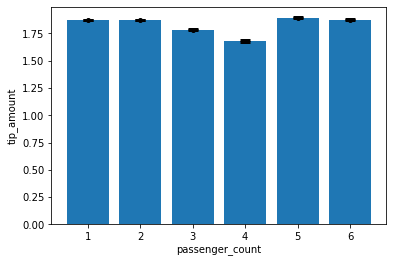

In [84]:
barplot(trips_df, 'passenger_count', 'tip_amount')

The ammount tipped seems to be consistent across the number of passengers

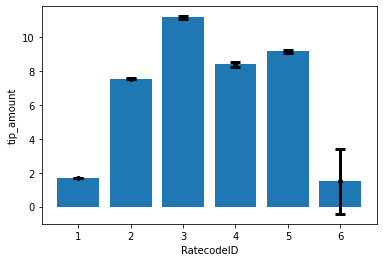

In [85]:
barplot(trips_df, 'RatecodeID', 'tip_amount')

Clients that are charged the standard rate leave less tips together with group rides. Newark rate translates into the best tips. Negotiated fares also leave good tips

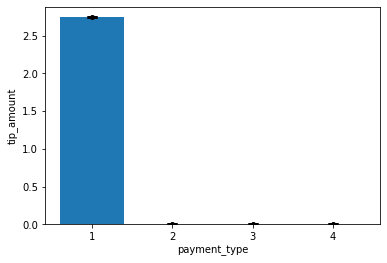

In [86]:
barplot(trips_df, 'payment_type', 'tip_amount')

This means that tips are only registered with the credit card. Therefore, if we want to analyse the impact of one variable in the tip we have to consider a dataset of only credit card paid trips.

Which areas are the ones that tip the most?. To do that let's visualise it in a map. To avoid a massive join between the trips dataframe and the geopandas dataframe lets group by area and join with the geopandas with the areas

<AxesSubplot:>

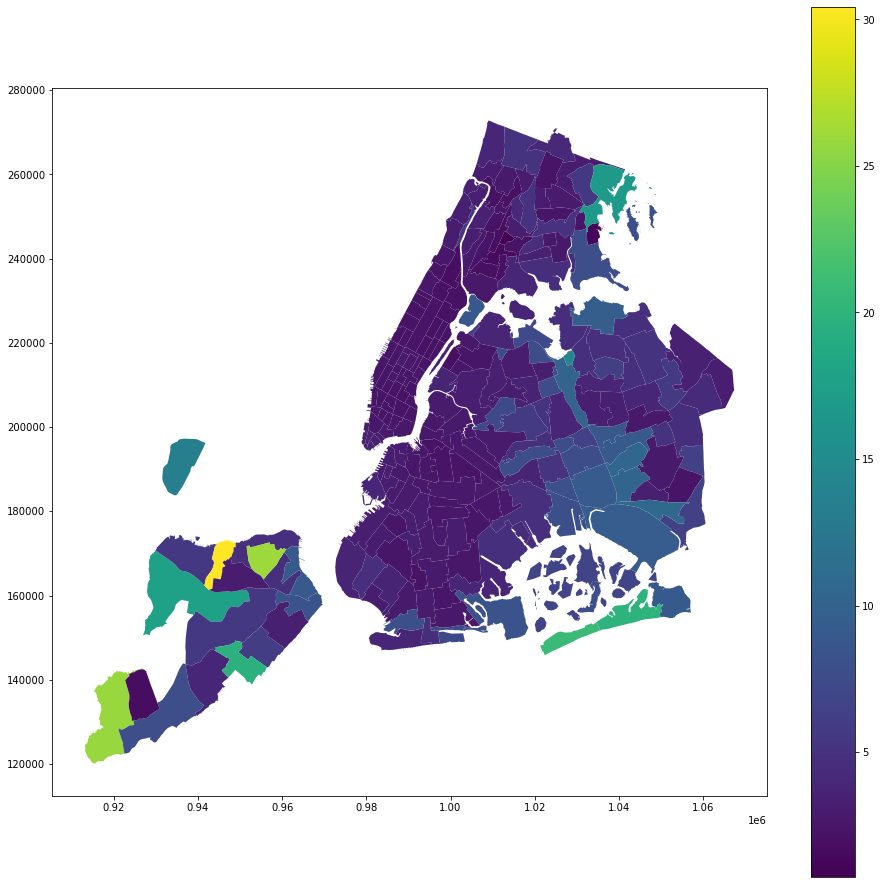

In [91]:
mean_tip_by_loc = trips_df[trips_df['payment_type']==1].groupby('PULocationID')['tip_amount'].mean().to_frame().reset_index()
taxi_zones_df = taxi_zones_df.merge(mean_tip_by_loc, left_on='LocationID', right_on='PULocationID')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16,16)
taxi_zones_df.plot(column='tip_amount',ax=ax, legend=True)

It seems like specific areas far from the city center leave larger tips. We have the feeling that this could be due to the fare amount since this means longer trips. Let's check that out 

<AxesSubplot:>

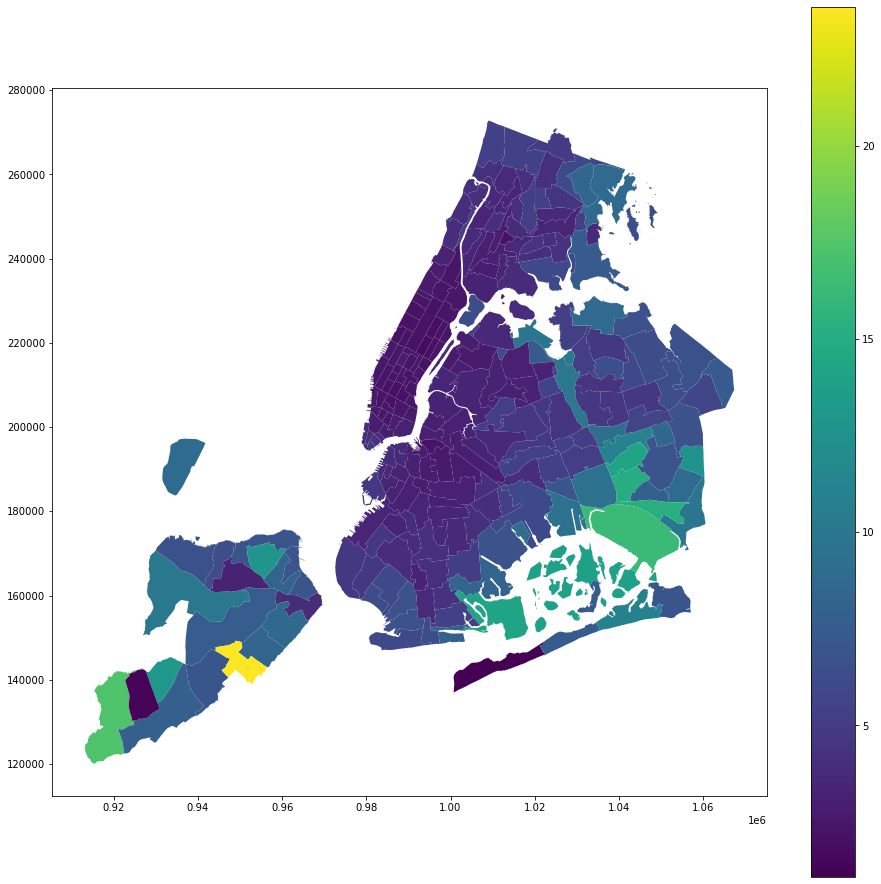

In [92]:
mean_trip_by_loc = trips_df[trips_df['payment_type']==1].groupby('PULocationID')['trip_distance'].mean().to_frame().reset_index()
taxi_zones_df = taxi_zones_df.merge(mean_trip_by_loc, left_on='LocationID', right_on='PULocationID')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16,16)
taxi_zones_df.plot(column='trip_distance',ax=ax, legend=True)

Indeed that's the case. Areas in the outskirts of New York have longer trips and, hence, larger tips. We can also check this correlation between variables 

In [93]:
trips_df['passenger_count_num'] = trips_df['passenger_count'].astype('int')
trips_df[trips_df['payment_type']==1].corr()

,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,fare_per_distance,passenger_count_num
trip_distance,1.000,0.939,0.102,-0.189,0.578,0.490,NaN,0.927,-0.220,0.013
fare_amount,0.939,1.000,0.080,-0.286,0.603,0.489,NaN,0.979,-0.136,0.011
extra,0.102,0.080,1.000,0.024,0.073,0.042,NaN,0.116,-0.027,0.004
mta_tax,-0.189,-0.286,0.024,1.000,-0.180,-0.316,NaN,-0.302,-0.052,0.002
tip_amount,0.578,0.603,0.073,-0.180,1.000,0.362,NaN,0.719,-0.098,-0.003
tolls_amount,0.490,0.489,0.042,-0.316,0.362,1.000,NaN,0.595,-0.062,0.007
improvement_surcharge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_amount,0.927,0.979,0.116,-0.302,0.719,0.595,NaN,1.000,-0.136,0.010
fare_per_distance,-0.220,-0.136,-0.027,-0.052,-0.098,-0.062,NaN,-0.136,1.000,-0.007
passenger_count_num,0.013,0.011,0.004,0.002,-0.003,0.007,NaN,0.010,-0.007,1.000


The tip is positively correlated with the fare and subsequently with the trip_distance. This tell us that the longer the trip the larger the tip which seems logical. The mta tax applied also reduces the ammount tipped slightly but seems to be caused by the negative correlation between the tolls paid and this mta tax. If less tolls are paid, the tip is going to be less (surprisingly) because the fare is less. High correlations between variables like trip distance <-> fare amount/total amount seem obvious and we have to be careful with them when training the model. 

This correlation also make us think that the time elapsed in the trip could be an important factor. Do customers pay less if they have been stuck in a traffic jam? Do they pay more tips if they complete a longer distance in a shorter time?

In [113]:
trips_credit_df = trips_df[trips_df['payment_type']==1]
trips_credit_df['tpep_pickup_datetime'] = pd.to_datetime(trips_credit_df['tpep_pickup_datetime'], infer_datetime_format=True)
trips_credit_df['tpep_dropoff_datetime'] = pd.to_datetime(trips_credit_df['tpep_dropoff_datetime'], infer_datetime_format=True)

C:\Users\BRANDON\miniconda3\envs\carto\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\BRANDON\miniconda3\envs\carto\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
trips_credit_df['time_elapsed_seconds'] = (trips_credit_df['tpep_dropoff_datetime'] - trips_credit_df['tpep_pickup_datetime']).dt.total_seconds()

C:\Users\BRANDON\miniconda3\envs\carto\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


With this metrics we can even detect 759 rows of bad data with 0 seconds elapsed. We eliminate those entries

In [115]:
trips_credit_df[trips_credit_df['time_elapsed_seconds']==0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,fare_per_distance,passenger_count_num,time_elapsed_seconds,time_per_mile


In [116]:
trips_credit_df = trips_credit_df[trips_credit_df['time_elapsed_seconds']!=0]


We are going to create a metric called time per mile, which basically tells us how fast that trip was. Maybe users where trips where really slow get pissed off and give less tips

In [117]:
trips_credit_df['time_per_mile'] = trips_credit_df['trip_distance']/trips_credit_df['time_elapsed_seconds']

Let's check again correlations with this variable

In [118]:
trips_credit_df[['time_elapsed_seconds','time_per_mile','trip_distance','tip_amount','fare_amount','fare_per_distance']].corr()

,time_elapsed_seconds,time_per_mile,trip_distance,tip_amount,fare_amount,fare_per_distance
time_elapsed_seconds,1.000,-0.004,0.187,0.153,0.206,-0.042
time_per_mile,-0.004,1.000,0.062,0.051,0.053,-0.014
trip_distance,0.187,0.062,1.000,0.755,0.941,-0.260
tip_amount,0.153,0.051,0.755,1.000,0.781,-0.127
fare_amount,0.206,0.053,0.941,0.781,1.000,-0.151
fare_per_distance,-0.042,-0.014,-0.260,-0.127,-0.151,1.000


<AxesSubplot:>

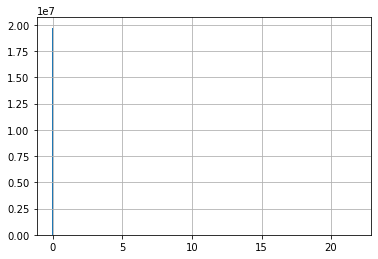

In [119]:
trips_credit_df[trips_credit_df['time_per_mile'] < 25]['time_per_mile'].hist(bins=200)

The time per mile is almost always the same and the time elapsed does not seem to be correlated to any of the important variables

Some additional plots to visualise the relation between the categorical variables store_and_fwd_flag + VendorID and the target variable. Surprisingly store_and_fwd_flag has an effect of about 0.5 dollars in the tip. The Vendor ID is not related at all as we expected

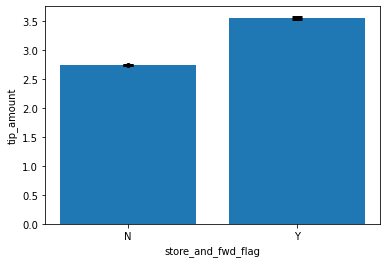

In [120]:
barplot(trips_credit_df, 'store_and_fwd_flag', 'tip_amount')

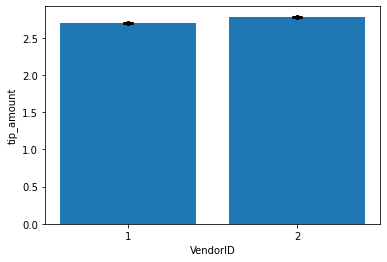

In [121]:
barplot(trips_credit_df, 'VendorID', 'tip_amount')

## Model Building

For a first approach to the model we are going to choose the boosted decision tree of catboost. Although it might be prone to overfitting, this seems like the kind of problem where you don't need a lot of generalisation power. Another advantage is that it provides good results out of the box and it handles the categorical values for us. It's also not impacted by multicollinearity. Finally, we do not have to scale the data

In [104]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.base import BaseEstimator, RegressorMixin

Based on our analysis we will keep only the following features of the dataset

In [105]:
features_to_keep = ['passenger_count_num', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type',
                    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'time_elapsed_seconds', 'store_and_fwd_flag']
categorical_features = ['RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type','store_and_fwd_flag']
dataset = trips_df[features_to_keep]
dataset[categorical_features] = dataset[categorical_features].astype('category')
dataset = dataset[dataset['payment_type'] == 1]  # Keep only credit cards as they are the ones that have tips as we saw before

C:\Users\BRANDON\miniconda3\envs\carto\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


There are 19728806 rows. For the sake of this exercise and to shorten training times let's take a sample. We could also scale this with technologies like Dask or Apache Spark. Another option could have been using a less computational intensive model with shorter computation times. 

In [106]:
sample_dataset = dataset.sample(700000)

How do we know if our model is any good?. Since we don't have any benchmark values with which to compare we are going to use a dummy model that outputs the mean. Another dummy model would be to calculate the mean tip by distance travelled and use that to calculate the tip of each trip. We create a Regressor that does that

In [107]:
class TipPerMileRegressor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.mean_ = np.mean(X[y != 0]['trip_distance'] / y[y != 0])
        return self

    def predict(self, X):
        return X['trip_distance'] * self.mean_

We train the model. We are going to use KFold to build the train and test sets. Note that we have to tell CatBoost which ones are the categorical values so it can handle them properly. The metrics we are going to use are MAE and MSE since this is a regression problem. MAE is the mean average error in the same units as the target variable, that means, dollars for the tip. MSE is the square and it's more senstiive to outliers so is worth considering it 

In [108]:
X = sample_dataset.drop('tip_amount', axis=1)
categorical_indexes = [X.columns.get_loc(c) for c in X.select_dtypes('category').columns]
Y = sample_dataset['tip_amount']
kfold = KFold(n_splits=3) # change the splits if necessary
scores_dict = {'mse_cb': [], 'mae_cb': [], 'mse_dummy': [], 'mae_dummy': [], 'mse_dummy2': [], 'mae_dummy2': []}
for train_index, test_index in kfold.split(sample_dataset):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    clf = CatBoostRegressor()
    clf.fit(x_train, y_train, cat_features=categorical_indexes)
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr2 = TipPerMileRegressor()
    dummy_regr.fit(x_train, y_train)
    dummy_regr2.fit(x_train, y_train)
    cb_pred = clf.predict(x_test)
    dummy_pred = dummy_regr.predict(x_test)
    dummy2_pred = dummy_regr2.predict(x_test)
    scores_dict['mse_cb'].append(mean_squared_error(y_test, cb_pred))
    scores_dict['mae_cb'].append(mean_absolute_error(y_test, cb_pred))
    scores_dict['mse_dummy'].append(mean_squared_error(y_test, dummy_pred))
    scores_dict['mae_dummy'].append(mean_absolute_error(y_test, dummy_pred))
    scores_dict['mse_dummy2'].append(mean_squared_error(y_test, dummy2_pred))
    scores_dict['mae_dummy2'].append(mean_absolute_error(y_test, dummy2_pred))

Learning rate set to 0.116542
0:	learn: 2.6322734	total: 297ms	remaining: 4m 56s
1:	learn: 2.4836313	total: 595ms	remaining: 4m 56s
2:	learn: 2.3604554	total: 874ms	remaining: 4m 50s
3:	learn: 2.2576634	total: 1.14s	remaining: 4m 44s
4:	learn: 2.1725388	total: 1.45s	remaining: 4m 48s
5:	learn: 2.1024635	total: 1.74s	remaining: 4m 47s
6:	learn: 2.0455072	total: 2s	remaining: 4m 44s
7:	learn: 1.9988693	total: 2.31s	remaining: 4m 46s
8:	learn: 1.9602345	total: 2.58s	remaining: 4m 43s
9:	learn: 1.9295133	total: 2.85s	remaining: 4m 42s
10:	learn: 1.9033456	total: 3.1s	remaining: 4m 38s
11:	learn: 1.8827228	total: 3.38s	remaining: 4m 38s
12:	learn: 1.8663633	total: 3.66s	remaining: 4m 37s
13:	learn: 1.8527831	total: 3.91s	remaining: 4m 35s
14:	learn: 1.8417515	total: 4.19s	remaining: 4m 35s
15:	learn: 1.8317839	total: 4.46s	remaining: 4m 34s
16:	learn: 1.8242372	total: 4.69s	remaining: 4m 31s
17:	learn: 1.8181116	total: 4.95s	remaining: 4m 30s
18:	learn: 1.8127985	total: 5.24s	remaining: 4m 

<AxesSubplot:xlabel='variable', ylabel='value'>

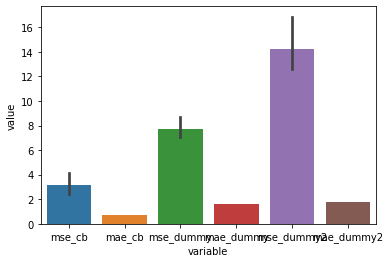

In [111]:
scores_df = pd.DataFrame(scores_dict)
sns.barplot(data=pd.melt(scores_df), x='variable', y='value')

In [112]:
scores_df

,mse_cb,mae_cb,mse_dummy,mae_dummy,mse_dummy2,mae_dummy2
0,2.899,0.735,7.339,1.628,13.240,1.767
1,2.396,0.733,7.056,1.633,12.570,1.741
2,4.170,0.738,8.713,1.631,16.842,1.758


Out model improves both dummy predictors (about 0.7 dollars on average). Surprisingly the mean dummy model is bettern than the "tip per mile" dummy model

### Discuss any limitations or caveats of the model which might be an issue in implementing it.

- Cleaning the data when it comes in real time. A pipeline should be used in train time. One of the steps of the pipeline is calculating the zscores to discard outlier values based on the distribution of the train set
- The tip suggestion should not be presented in the app or system when the trip length is 0
- The tip suggestion can be shown even when paying in cash although we train only with the credit card values.

### Disccus how you might improve your model going forward

- Hyperparameter tuning
- Trying other models: linear regression (might need more preprocessing), Ridge Regression, Neural Networks etc...
- Additional geospatial and demographics information regarding the zones of origin and destination (purchasing power, points of interest, etc...)
- Additional information regarding the hour of the day. Do people tip more at night? during the evening? during the afternoon? (this however does not makes much sense from the suggesting tip point of view as we might think that the tip should depend on the length of the trip and the elapsed time itself

### Discuss how you might turn this model in to an API the company can use.

I would deploy the model into a cloud service such as Azure.
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-and-where?tabs=azcli
From here you can run any prediction as a rest call. More info here:
https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-pipeline-batch-scoring-classification#publish-and-run-from-a-rest-endpoint
The advantages of this approach is that you get all the advantages of MLOps for machine learning. You can:
- Keep track and store your models and metada
- Rollback to previous models in case you find any bugs or strange behaviour in the predictions
- If you store the data in the same cloud service the model will be trained next to where the data resides.
- Lower costs when training and elastic resources

Another option if cloud is not possible (because of client requirements) would be to store the models in a cache such as REDIS. Or we can build our own microservices using Docker and a lightweight framework for the rest service such as Flask.